In [1]:
# 导入常用库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')  # 忽略所有 UserWarning

In [2]:
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 正确显示负号

## 数据加载与预处理

在本部分，我们完成了乳腺癌数据的读取与基础预处理操作，具体说明如下：
### 1. 数据加载
首先读取了数据，文件中包含l多个肿瘤特征字段。其中，原始数据中有两列冗余字段，可直接删除：
- `'id'`：患者编号，对模型训练无意义；
- `'Unnamed: 32'`：全为空值列，可直接删除。

### 2. 标签编码
`diagnosis` 列表示肿瘤诊断结果，并把结果转换为数值型二分类标签，其中：
- `'M'` 表示恶性为1；
- `'B'` 表示良性为0。

### 3. 特征与标签分离
将诊断结果列作为标签 `y`，其余所有列作为特征 `X`.

### 4. 数据集划分
数据划分训练集与测试集比例为 80% / 20%并设定了随机种子 `random_state=42` 。

### 5. 特征标准化
考虑到各个特征量纲不同，所以对特征进行标准化处理。

In [3]:
# 加载数据
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

df = pd.read_csv('breast cancer.csv')
df = df.drop(['id', 'Unnamed: 32'], axis=1)
df['diagnosis'] = df['diagnosis'].map({'M':1, 'B':0})

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

我们可以通过前五行数据来进行观察：

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 显示前5行数据
print("数据预览：佘祎凡2023217427")
display(df.head())

数据预览：佘祎凡2023217427


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678



诊断标签分布：佘祎凡
diagnosis
0    357
1    212
Name: count, dtype: int64


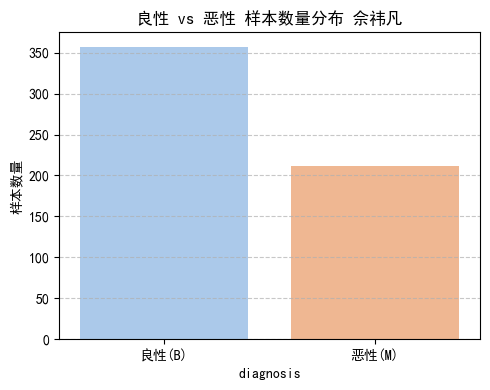

In [5]:
# 诊断类别数量
print("\n诊断标签分布：佘祎凡")
print(df['diagnosis'].value_counts())

# 画出诊断类别数量的柱状图
plt.figure(figsize=(5,4))
sns.countplot(x='diagnosis', data=df, palette='pastel')
plt.title("良性 vs 恶性 样本数量分布 佘祎凡")
plt.xticks([0,1], ['良性(B)', '恶性(M)'])
plt.ylabel("样本数量")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

由上图可知，良性样本：恶性样本=2：1（大约），虽然类别不完全均衡，但也不严重失衡。

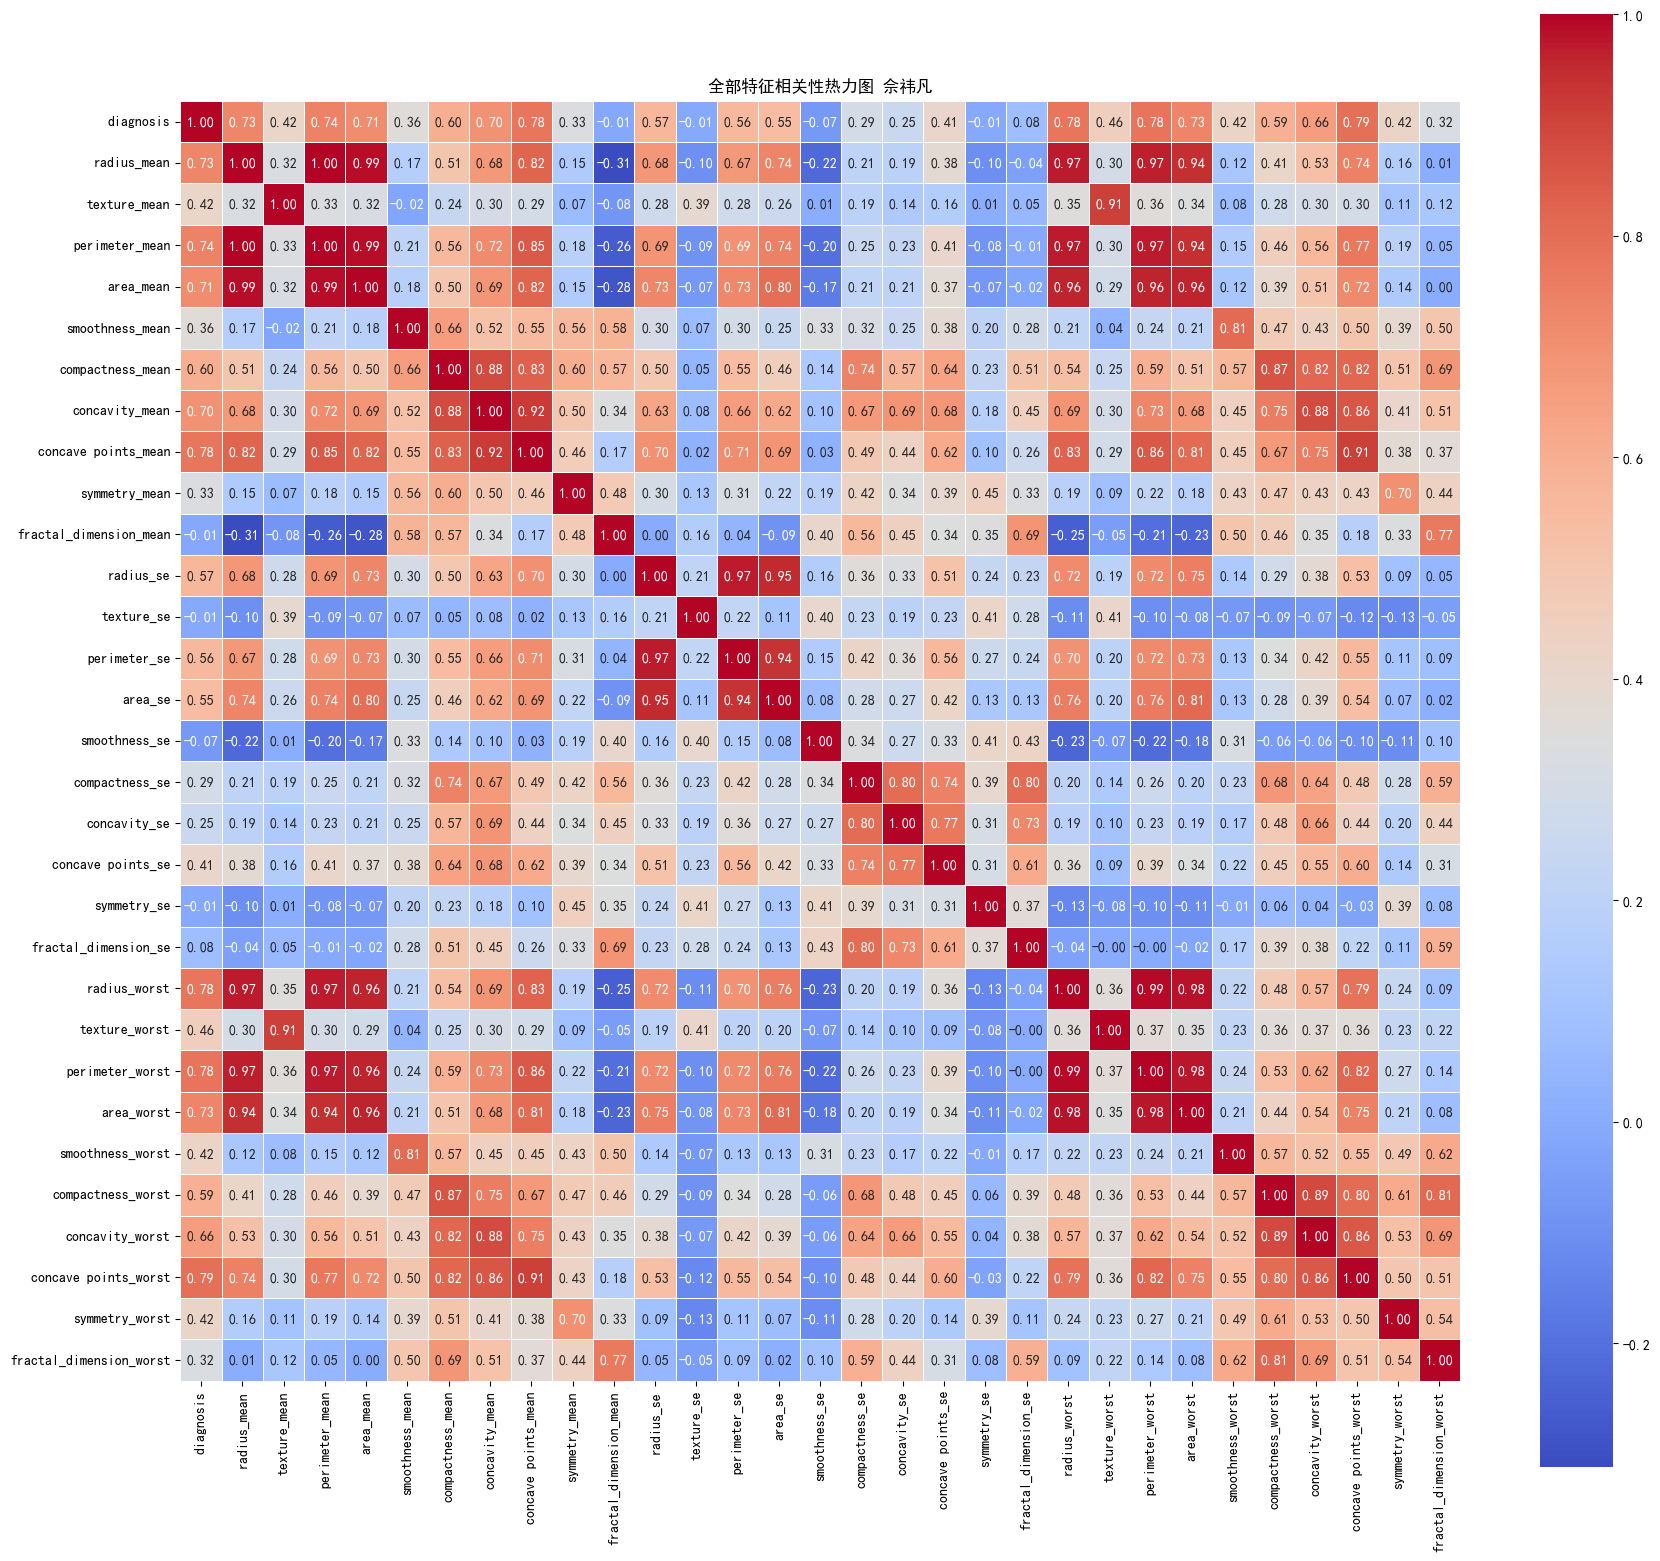

In [6]:
# 显示所有特征的相关性热力图
plt.figure(figsize=(18,16))  
corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("全部特征相关性热力图 佘祎凡")
plt.tight_layout()
plt.show()

由图知：
- 多个特征与 diagnosis 显著相关，特别是： `concave points_mean`、`radius_mean`、`perimeter_mean`、`area_mean` 均呈强正相关（r > 0.7）；
- 特征冗余现象显著， `radius_mean`、`perimeter_mean`、`area_mean` 三者相关系数接近 1。

接下来查看以下四个关键特征的分布：
- `'radius_mean'`：肿瘤半径的平均值；
- `'texture_mean'`：肿瘤表面纹理的平均值；
- `'perimeter_mean'`：肿瘤周长的平均值；
- `'area_mean'`：肿瘤面积的平均值。

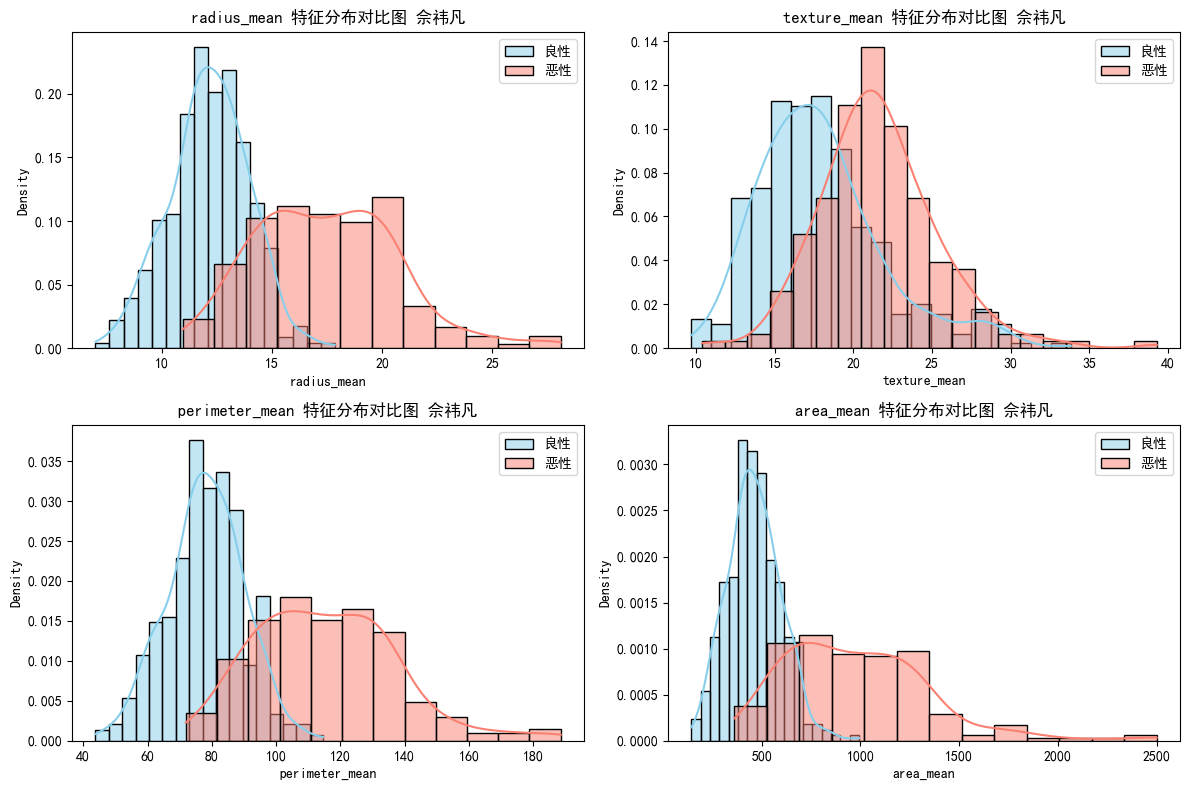

In [7]:
features_to_plot = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean']
df_benign = df[df['diagnosis'] == 0]
df_malignant = df[df['diagnosis'] == 1]

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_benign[feature], color='skyblue', label='良性', kde=True, stat="density")
    sns.histplot(df_malignant[feature], color='salmon', label='恶性', kde=True, stat="density")
    plt.title(f"{feature} 特征分布对比图 佘祎凡")
    plt.legend()
    plt.xlabel(feature)
plt.tight_layout()
plt.show()

从图中我们可以看出：
- radius_mean, perimeter_mean, area_mean 对分类有较强区分力；
- 恶性肿瘤在这些特征上分布较偏右（数值更大）；
- texture_mean 的分布差异相对较小，区分能力有限。

In [8]:
# 找出相关系数矩阵的上三角
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 找出高度相关的列
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print("建议删除的冗余特征列：", to_drop)

# 删除这些列
X = X.drop(columns=to_drop)


建议删除的冗余特征列： ['perimeter_mean', 'area_mean', 'concave points_mean', 'perimeter_se', 'area_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'concave points_worst']


In [9]:
#XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

y_proba_xgb = xgb.predict_proba(X_test)[:,1]
y_pred_xgb = xgb.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

print("XGBoost 分类报告：")
print(report_xgb)
print(f"准确率：{acc_xgb:.4f}")

XGBoost 分类报告：
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

准确率：0.9561


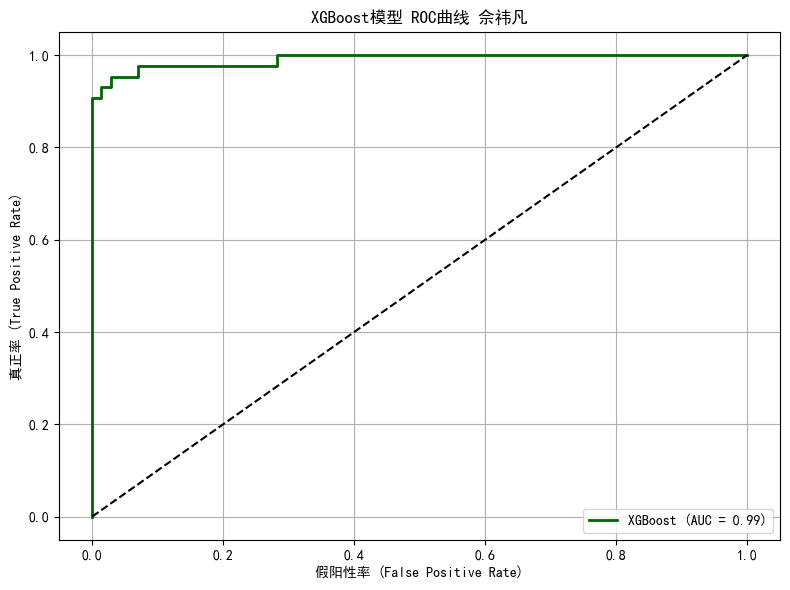

In [10]:
# ROC曲线
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_xgb, tpr_xgb, color='darkgreen', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.title('XGBoost模型 ROC曲线 佘祎凡')
plt.xlabel('假阳性率 (False Positive Rate)')
plt.ylabel('真正率 (True Positive Rate)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

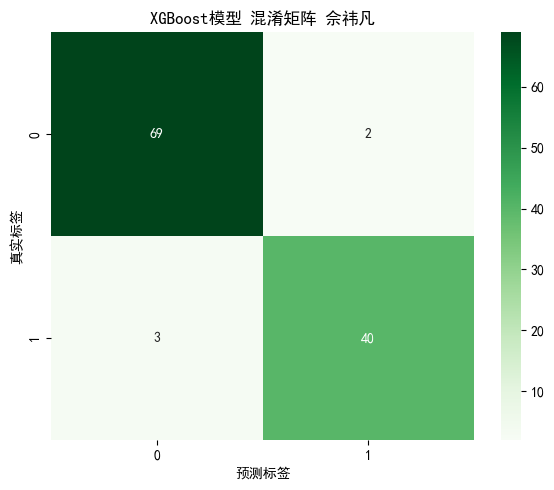

In [11]:
# 混淆矩阵
plt.figure(figsize=(6,5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens')
plt.title('XGBoost模型 混淆矩阵 佘祎凡')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.tight_layout()
plt.show()

In [12]:
# ========== TensorFlow DNN 模型 ==========
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0
)

In [14]:
y_proba_dnn = model.predict(X_test).ravel()
y_pred_dnn = (y_proba_dnn > 0.5).astype(int)

acc_dnn = accuracy_score(y_test, y_pred_dnn)
cm_dnn = confusion_matrix(y_test, y_pred_dnn)
report_dnn = classification_report(y_test, y_pred_dnn)

print("\nTensorFlow DNN 分类报告：")
print(report_dnn)
print(f"准确率：{acc_dnn:.4f}")

4/4 [==============================] - 0s 5ms/step

TensorFlow DNN 分类报告：
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        71
           1       0.93      0.98      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

准确率：0.9649


In [15]:
fpr_dnn, tpr_dnn, _ = roc_curve(y_test, y_proba_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

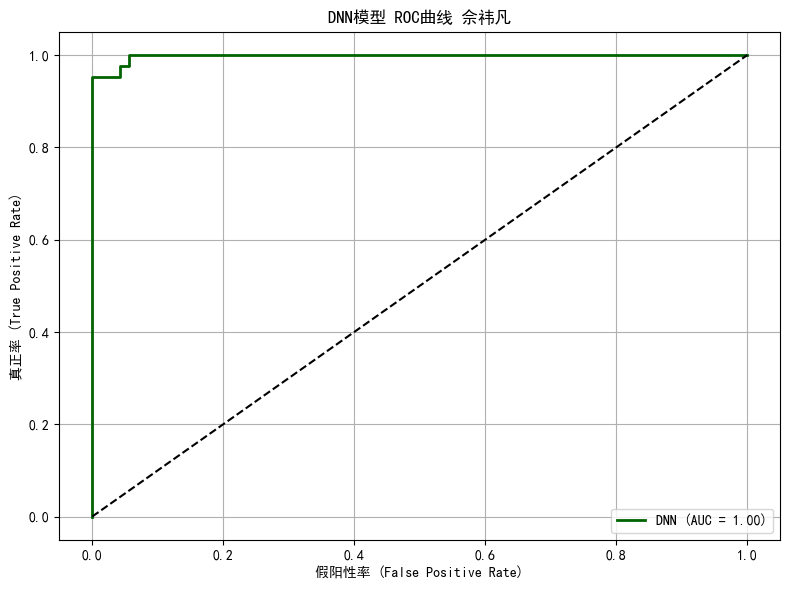

In [16]:
plt.figure(figsize=(8,6))
plt.plot(fpr_dnn, tpr_dnn, color='darkgreen', lw=2, label=f'DNN (AUC = {roc_auc_dnn:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.title('DNN模型 ROC曲线 佘祎凡')
plt.xlabel('假阳性率 (False Positive Rate)')
plt.ylabel('真正率 (True Positive Rate)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

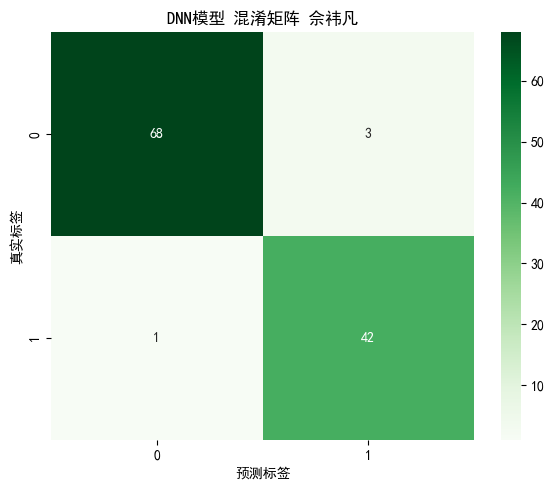

In [17]:
plt.figure(figsize=(6,5))
sns.heatmap(cm_dnn, annot=True, fmt='d', cmap='Greens')
plt.title('DNN模型 混淆矩阵 佘祎凡')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.tight_layout()
plt.show()

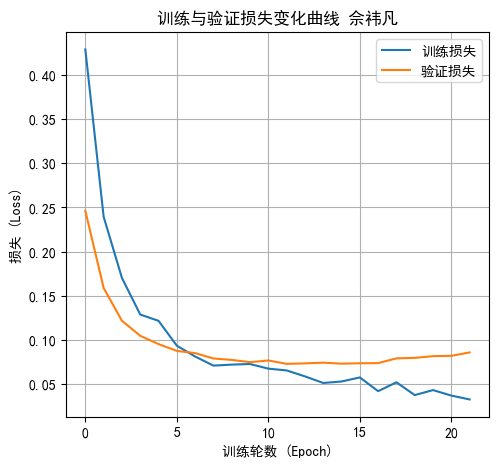

In [18]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.title('训练与验证损失变化曲线 佘祎凡')
plt.xlabel('训练轮数 (Epoch)')
plt.ylabel('损失 (Loss)')
plt.legend()
plt.grid(True)

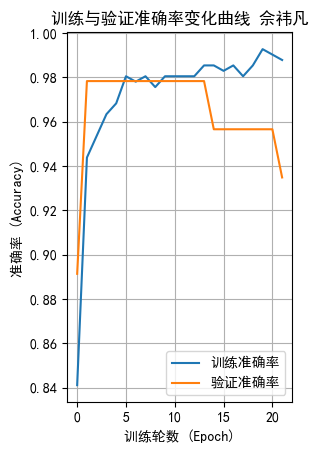

In [19]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='训练准确率')
plt.plot(history.history['val_accuracy'], label='验证准确率')
plt.title('训练与验证准确率变化曲线 佘祎凡')
plt.xlabel('训练轮数 (Epoch)')
plt.ylabel('准确率 (Accuracy)')
plt.legend()
plt.grid(True)

In [20]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [21]:
# ========== 不同深度的 DNN 模型结构对比实验 ==========
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc


In [22]:
# 定义三个不同深度的模型结构
def build_dnn_model(layers):
    model = Sequential()
    for i, (units, drop) in enumerate(layers):
        if i == 0:
            model.add(Dense(units, activation='relu', input_shape=(X_train.shape[1],)))
        else:
            model.add(Dense(units, activation='relu'))
        if drop > 0:
            model.add(Dropout(drop))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [23]:
# 模型结构字典
architectures = {
    "DNN-2层": [(32, 0.0)],
    "DNN-3层": [(64, 0.3), (32, 0.0)],
    "DNN-4层": [(128, 0.3), (64, 0.3), (32, 0.0)]
}

In [24]:
results_dnn = {}


In [25]:
# 提前停止设置
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [26]:
# 训练与评估
for name, layers in architectures.items():
    model = build_dnn_model(layers)
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=16,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0
    )

    y_proba = model.predict(X_test).ravel()
    y_pred = (y_proba > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    results_dnn[name] = {
        "model": model,
        "accuracy": acc,
        "confusion_matrix": cm,
        "report": report,
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc,
        "history": history
    }

4/4 [==============================] - 0s 4ms/step


In [27]:
# ========== 可视化结果 ==========
import matplotlib.pyplot as plt
import seaborn as sns



Text(0, 0.5, 'Accuracy')

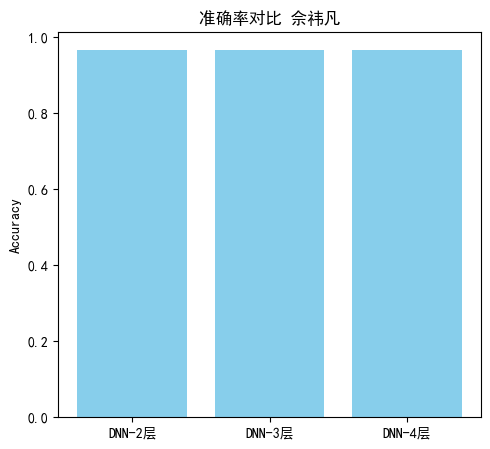

In [28]:
# 准确率比较
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
accs = [results_dnn[name]['accuracy'] for name in architectures]
plt.bar(architectures.keys(), accs, color='skyblue')
plt.title('准确率对比 佘祎凡')
plt.ylabel('Accuracy')

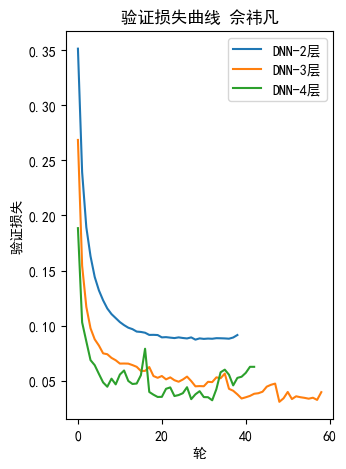

In [29]:
# 验证损失曲线
plt.subplot(1, 2, 2)
for name in architectures:
    plt.plot(results_dnn[name]['history'].history['val_loss'], label=name)
plt.title('验证损失曲线 佘祎凡')
plt.xlabel('轮')
plt.ylabel('验证损失')
plt.legend()
plt.tight_layout()
plt.show()

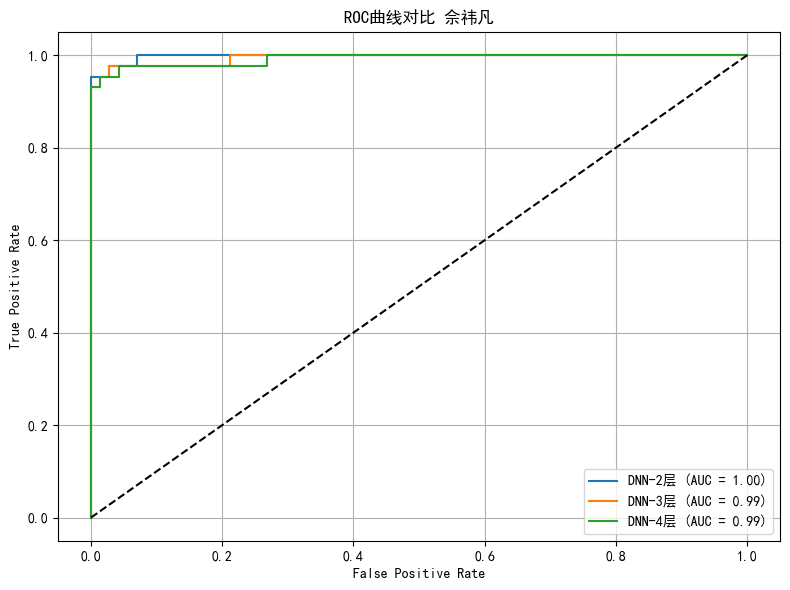

In [30]:
# ROC 曲线比较
plt.figure(figsize=(8, 6))
for name in architectures:
    fpr = results_dnn[name]['fpr']
    tpr = results_dnn[name]['tpr']
    auc_score = results_dnn[name]['auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC曲线对比 佘祎凡')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

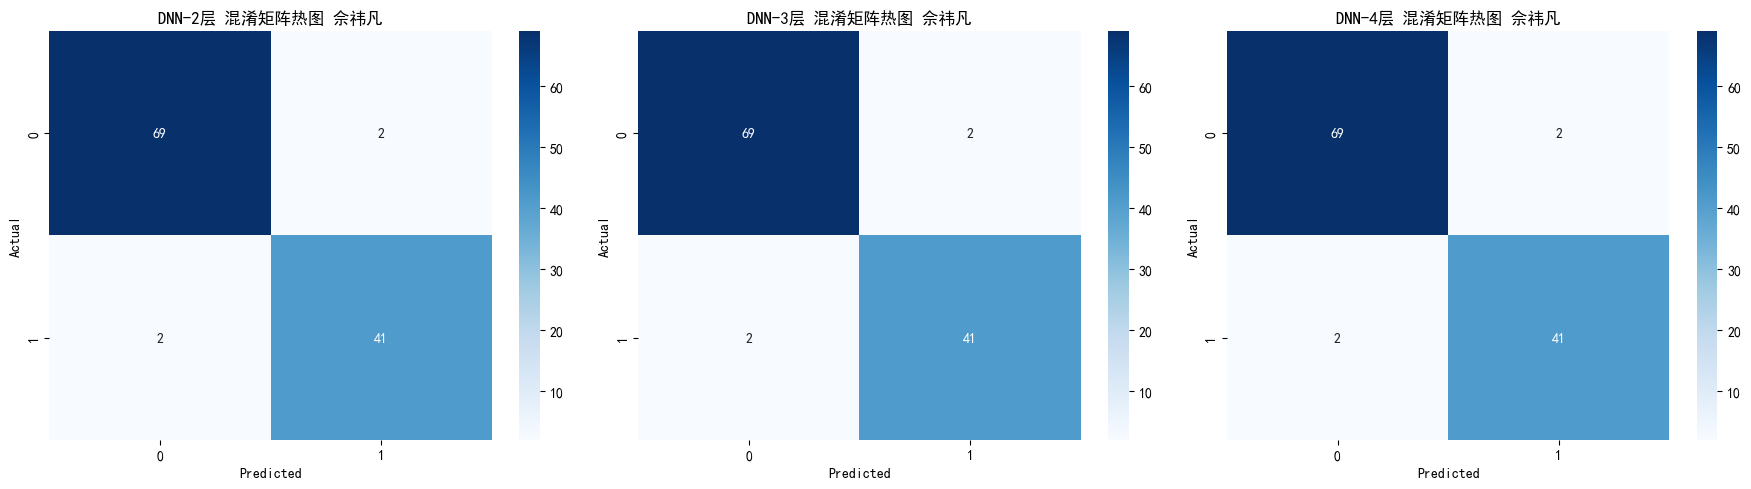

In [31]:
# 混淆矩阵热图
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (name, res) in enumerate(results_dnn.items()):
    sns.heatmap(res['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name} 混淆矩阵热图 佘祎凡')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
plt.tight_layout()
plt.show()

# 接下来是使用多层感知机分类模型

In [32]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 创建 MLP 分类器
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # 两个隐藏层，节点数分别为 100 和 50
    activation='relu',             # 激活函数使用 ReLU
    solver='adam',                 # 使用 Adam 优化器
    max_iter=500,                  # 最大迭代次数
    random_state=42
)

### 进行模型训练和预测

In [33]:
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)
y_prob_mlp = mlp_model.predict_proba(X_test)[:, 1]

### 混淆矩阵与分类报告

混淆矩阵：
[[70  1]
 [ 2 41]]


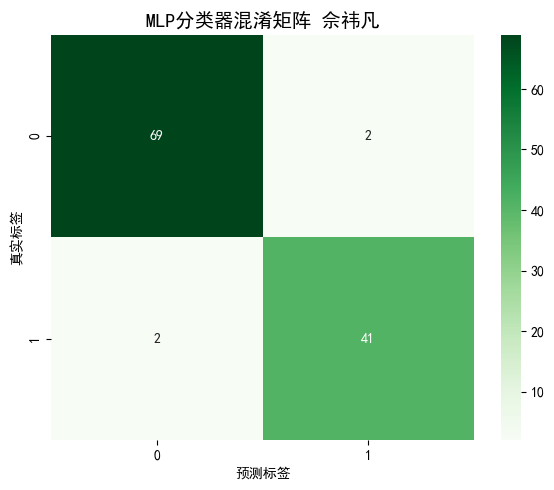

In [34]:
print("混淆矩阵：")
print(confusion_matrix(y_test, y_pred_mlp))
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')

plt.title('MLP分类器混淆矩阵 佘祎凡', fontsize=14)
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.tight_layout()
plt.show()

In [35]:
print("分类报告：")
print(classification_report(y_test, y_pred_mlp))
acc_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"准确率：{acc_mlp:.4f}")

分类报告：
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

准确率：0.9737


### ROC 曲线

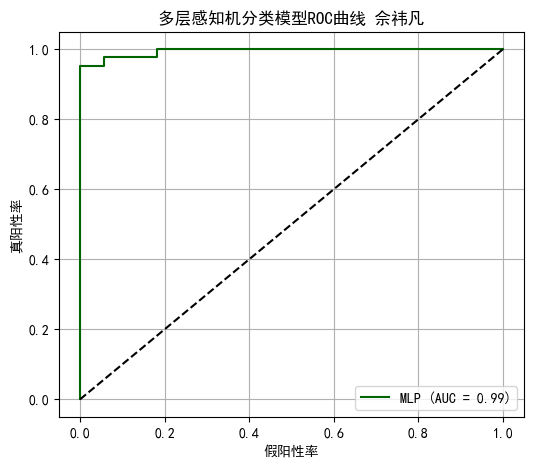

In [36]:
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure(figsize=(6, 5))
plt.plot(fpr_mlp, tpr_mlp, label='MLP (AUC = %0.2f)' % roc_auc_mlp, color='darkgreen')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('多层感知机分类模型ROC曲线 佘祎凡')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()